Considerations:
1. Feature Relevance
2. Dimensionality: PCA or t-SNE reduction can be useful
3. Cluster Interpretability

Dataset can incorporate internal company features as follows:
1. Instead of Publication Rate, Industry Orientation etc. modify features in the form "Need for publications/industry collaborations/ members etc. so that interpretation of strengths and weaknesses is uniform.

In [227]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture


In [177]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [123]:
!pip install umap

In [124]:
!pip install kneed
from kneed import KneeLocator

In [228]:
expanded_involvement_columns = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                                'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                                'Funding', 'Application-Oriented', 'Cybersecurity', 'Biotech', 
                                'FinTech', 'Agritech', 'MedTech', 'ClimateTech', 'EdTech', 
                                'Renewable Energy', 'Telecom', 'E-commerce']
granular_strength_map = {f'Level {i}': i for i in range(11)}

In [223]:
def load_and_preprocess_data(file_path):
 
    data = pd.read_csv(file_path, index_col=0).transpose()
    data = data.replace(granular_strength_map).infer_objects(copy=False)
    
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    print(data.head())
    
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    return data_scaled

In [247]:
def identify_industry_columns(data):
    #FIXME: 'Funding' and 'Application-Oriented' should not to be there!
    keywords = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                                'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                                'Funding', 'Application-Oriented', 'Cybersecurity', 'Biotech', 
                                'FinTech', 'Agritech', 'MedTech', 'ClimateTech', 'EdTech', 
                                'Renewable Energy', 'Telecom', 'E-commerce']
    industry_columns = [col for col in data.columns if any(keyword in col for keyword in keywords)]
    return industry_columns

In [248]:
file_path = 'data/new_synthetic_data.csv'
preprocessed_data = load_and_preprocess_data(file_path)

        Security  Humanities  Nat. Sci  Health  AI Ethics  Big Data  Robotics  \
Team_0         1           6         3       0         10         1        10   
Team_1         1           4         6       3          0         2         2   
Team_2         5          10         4       5          4         3         1   
Team_3        10           1         3       3          4         0         2   
Team_4         8           1         1       1          4         4         3   

        Documents  Multimedia  NLP  ...  Cybersecurity  Biotech  FinTech  \
Team_0          8           6    7  ...              2        3        6   
Team_1         10           4    1  ...              0       10        3   
Team_2          1           0    7  ...              5        7       10   
Team_3          5           1    5  ...              5        9        2   
Team_4          7           2    5  ...              5        2        6   

        Agritech  MedTech  ClimateTech  EdTech  Renewabl

/var/folders/fm/9tf79c_d1691c4jwk2qqr42m0000gn/T/ipykernel_58578/4208944868.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(granular_strength_map).infer_objects(copy=False)


In [211]:
preprocessed_data.head()

,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,Cybersecurity,Biotech,FinTech,Agritech,MedTech,ClimateTech,EdTech,Renewable Energy,Telecom,E-commerce
Team_0,-1.239841,0.341795,-0.629192,-1.573189,1.562427,-1.293851,1.568318,0.980011,0.325381,0.583654,...,-0.958007,-0.607981,0.268653,0.335345,-0.049664,0.934229,-1.251490,-1.355702,0.675313,-0.309804
Team_1,-1.239841,-0.289989,0.314596,-0.639730,-1.569945,-0.976030,-0.903908,1.628166,-0.315764,-1.326834,...,-1.606623,1.586896,-0.686274,1.626374,0.578998,-1.633215,0.645665,-1.032454,0.675313,0.948283
Team_2,0.044636,1.605363,-0.314596,-0.017425,-0.316996,-0.658208,-1.212936,-1.288533,-1.598054,0.583654,...,0.014918,0.646235,1.541888,-0.632927,1.521992,-0.670424,-0.302912,1.230282,-1.546112,-0.938848
Team_3,1.650231,-1.237664,-0.629192,-0.639730,-0.316996,-1.611673,-0.903908,0.007778,-1.277481,-0.053175,...,0.014918,1.273342,-1.004583,-0.632927,-0.678327,0.292368,-1.251490,-0.062710,0.675313,1.262805
Team_4,1.007993,-1.237664,-1.258384,-1.262036,-0.316996,-0.340387,-0.594879,0.655933,-0.956909,-0.053175,...,0.014918,-0.921535,0.268653,-1.278442,1.521992,-1.633215,0.013280,-1.678950,0.357967,0.319240


In [249]:
industry_columns = identify_industry_columns(preprocessed_data)
industry_data = preprocessed_data[industry_columns]

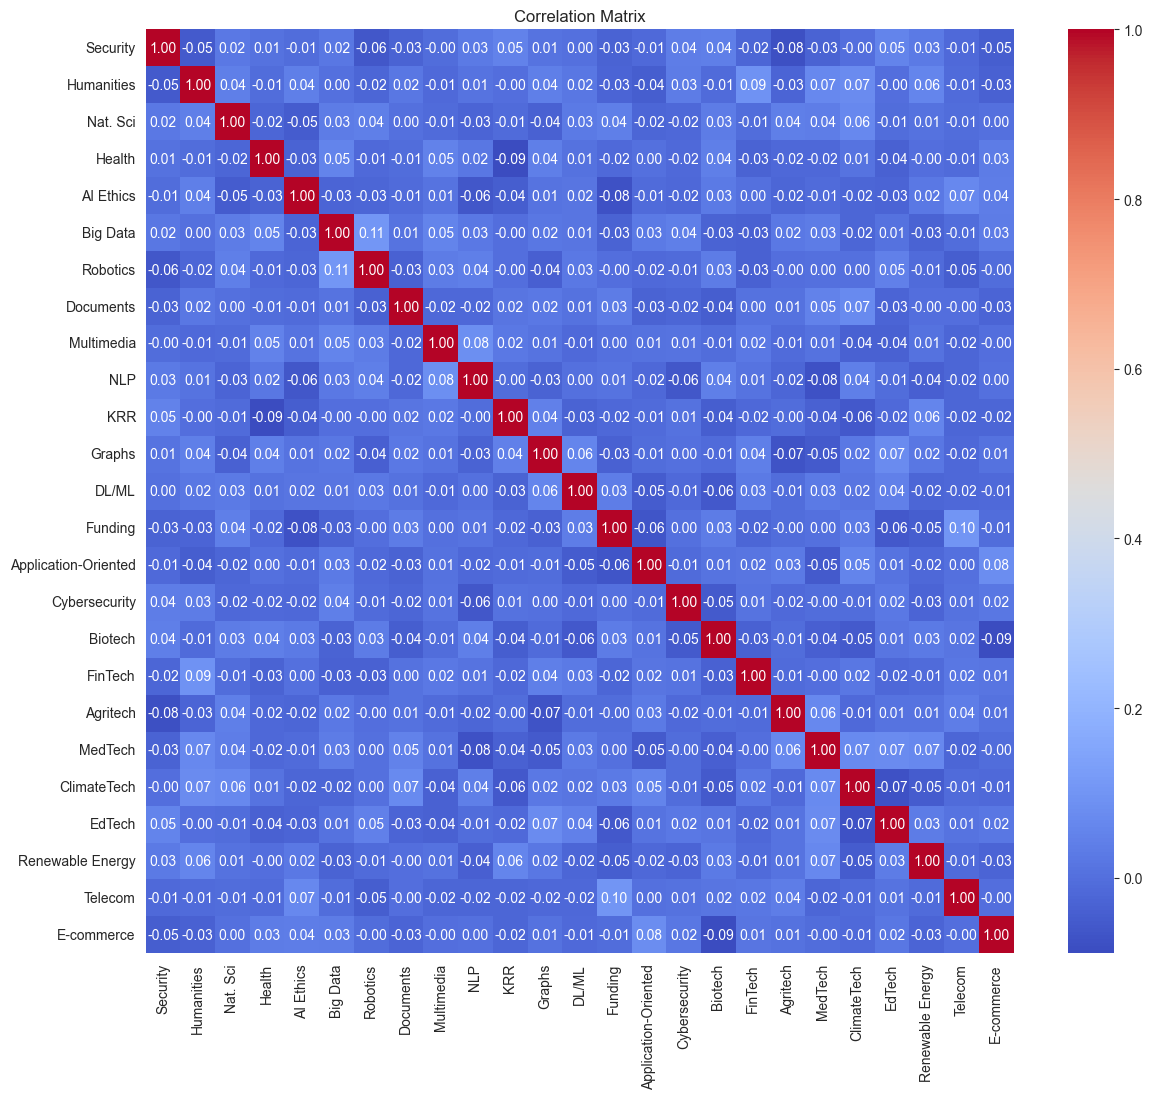

In [250]:
# Calculate correlation matrix
correlation_matrix = industry_data.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [251]:
def get_highly_correlated_pairs(correlation_matrix, threshold=0.1):
    correlated_pairs = []
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i,j]) >= threshold and (i != j):
                correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
    return correlated_pairs

highly_correlated_pairs = get_highly_correlated_pairs(correlation_matrix)
for pair in highly_correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

Big Data - Robotics: 0.11
Robotics - Big Data: 0.11
Funding - Telecom: 0.10
Telecom - Funding: 0.10


Feature Engineering
1. Interaction features: Capture relationships between two or more features. Can lead to high-dimensional feature space which requires regularization or feature selection
2. Polynomial features: Capture non-linear relationships between features. Degree needs to be low to avoid overfitting
3. Statistical features: Summarize distribution of values. Make sure features provide meaningful information in learning process

In [252]:
def add_interaction_features(data): 
    #FIXME: Refine interaction terms. This is a baseline implementation with no real insights into what industry terms should interact. Interaction will depend on the specific needs of the user.
    
    # Create a new DataFrame to store the aggregate features for each team
    aggregate_features = pd.DataFrame(index=data.index)
    
    aggregate_features['AI_Health_Interaction'] = data['AI Ethics'] * data['Health']
    aggregate_features['AI_BigData_Interaction'] = data['AI Ethics'] * data['Big Data']
    aggregate_features['Health_NatSci_Interaction'] = data['Health'] * data['Nat. Sci']
    aggregate_features['Robotics_Documents_Interaction'] = data['Robotics'] * data['Documents']
    aggregate_features['NLP_KRR_Interaction'] = data['NLP'] * data['KRR']
    aggregate_features['Graphs_DLML_Interaction'] = data['Graphs'] * data['DL/ML']

    # Sum interaction features
    aggregate_features['AI_BigData_Sum'] = data['AI Ethics'] + data['Big Data']
    aggregate_features['Health_NatSci_Sum'] = data['Health'] + data['Nat. Sci']

    # Difference interaction features
    aggregate_features['AI_BigData_Diff'] = data['AI Ethics'] - data['Big Data']
    aggregate_features['Health_NatSci_Diff'] = data['Health'] - data['Nat. Sci']


    return aggregate_features

In [ ]:
#FIXME: Might need to add polynomial/statistical features. Train and evaluate results
"""def add_polynomial_features(data, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(data)
    poly_features_names = poly.get_feature_names_out()
    
    return pd.DataFrame(poly_features_names, columns=poly_features_names, index=data.index)
    """

In [ ]:
"""
data_poly = add_polynomial_features(data_scaled, degree=2)
data_interact = add_interaction_features(data_scaled)

combined_data = pd.concat([data_poly, data_interact], axis=1)
"""

In [253]:
# Add interaction features to the preprocessed data
interaction_features = add_interaction_features(industry_data)

In [254]:
# Combine the interaction features with the original preprocessed data
combined_data = pd.concat([industry_data, interaction_features], axis=1)

combined_data.head()

,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,AI_Health_Interaction,AI_BigData_Interaction,Health_NatSci_Interaction,Robotics_Documents_Interaction,NLP_KRR_Interaction,Graphs_DLML_Interaction,AI_BigData_Sum,Health_NatSci_Sum,AI_BigData_Diff,Health_NatSci_Diff
Team_0,-1.239841,0.341795,-0.629192,-1.573189,1.562427,-1.293851,1.568318,0.980011,0.325381,0.583654,...,-2.457993,-2.021549,0.989838,1.536969,0.951257,-1.972398,0.268576,-2.202381,2.856279,-0.943996
Team_1,-1.239841,-0.289989,0.314596,-0.639730,-1.569945,-0.976030,-0.903908,1.628166,-0.315764,-1.326834,...,1.004341,1.532313,-0.201257,-1.471712,-2.162514,-1.172438,-2.545975,-0.325134,-0.593915,-0.954326
Team_2,0.044636,1.605363,-0.314596,-0.017425,-0.316996,-0.658208,-1.212936,-1.288533,-1.598054,0.583654,...,0.005524,0.208649,0.005482,1.562907,0.761423,-1.176180,-0.975204,-0.332021,0.341212,0.297172
Team_3,1.650231,-1.237664,-0.629192,-0.639730,-0.316996,-1.611673,-0.903908,0.007778,-1.277481,-0.053175,...,0.202792,0.510894,0.402513,-0.007030,-0.000190,0.951498,-1.928669,-1.268922,1.294677,-0.010538
Team_4,1.007993,-1.237664,-1.258384,-1.262036,-0.316996,-0.340387,-0.594879,0.655933,-0.956909,-0.053175,...,0.400060,0.107901,1.588126,-0.390201,-0.000190,1.273628,-0.657383,-2.520420,0.023391,-0.003651


In [255]:
#Dimenstionality Reduction to identify most relevant features
pca = PCA(n_components=0.95)
pca.fit(combined_data)

important_features = np.argsort(np.abs(pca.components_).sum(axis=0))[-10:]
important_feature_names = combined_data.columns[important_features]


print("Important features identified by PCA:", important_feature_names)

Important features identified by PCA: Index(['Documents', 'NLP', 'Graphs', 'AI_BigData_Interaction', 'Robotics',
       'Renewable Energy', 'KRR', 'Telecom', 'NLP_KRR_Interaction', 'FinTech'],
      dtype='object')


Cumulative variance explained by PCA: [0.08455645 0.16501649 0.24062483 0.31227509 0.3457292  0.37871174
 0.41081077 0.44203069 0.47245272 0.50223036 0.53101433 0.55943141
 0.58738365 0.61467614 0.64135367 0.66690075 0.69217135 0.71730782
 0.74217224 0.76629569 0.7901425  0.81329468 0.83620891 0.85825948
 0.8801854  0.90173428 0.9231494  0.94413002 0.96377772 0.98290745
 1.         1.         1.         1.         1.        ]


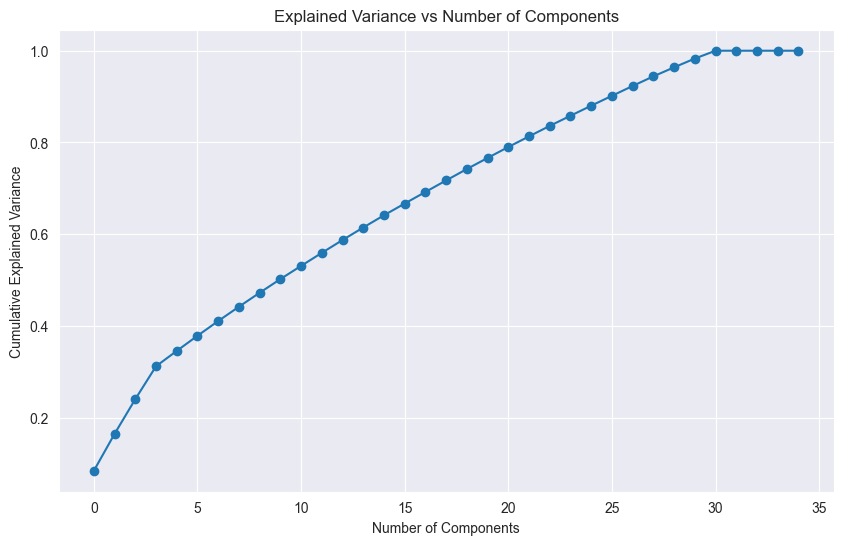

In [256]:
pca = PCA()
pca.fit(combined_data)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative variance explained by PCA:", cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [257]:
# Determine the number of components needed to capture 95% of the variance
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f'Number of components to retain {desired_variance*100}% variance: {n_components}')


Number of components to retain 95.0% variance: 29


In [188]:
"""
pca = PCA(n_components=n_components)
combined_data= pca.fit_transform(combined_data)

# Print the shape of the reduced data
print(f'Shape of the reduced data: {combined_data.shape}')
"""

"\npca = PCA(n_components=n_components)\ncombined_data= pca.fit_transform(combined_data)\n\n# Print the shape of the reduced data\nprint(f'Shape of the reduced data: {combined_data.shape}')\n"

Hyperparameter Optimization
-Adjusting encoding dimension
-Learning Rate and Epochs
-Additional Layers

In [258]:
def create_autoencoder(input_dim, encoding_dim, layer_sizes, dropout_rate=0.2):
    
    """
    Creates an autoencoder model with the specified architecture.
    
    Parameters:
    input_dim (int): The dimension of the input data.
    encoding_dim (int): The dimension of the encoded representation (bottleneck layer).
    layer_sizes (list of int): A list containing the sizes of the layers in the encoder. 
                               The decoder will have layers in the reverse order.
    dropout_rate (float): The dropout rate for regularization. Default is 0.2.
    
    Returns:
    Model: A compiled Keras Model object representing the autoencoder.
    
    The autoencoder architecture consists of:
    - An encoder: Layers that reduce the input dimension to the encoding dimension.
    - A bottleneck (encoded) layer: The compressed representation of the input data.
    - A decoder: Layers that reconstruct the input data from the encoded representation.
    """
    
    input_layer = Input(shape=(input_dim,), name='input_layer')
    x = input_layer
    
    for size in layer_sizes:
        x = Dense(size)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
    
    encoded = Dense(encoding_dim, activation='relu', name='encoded_layer')(x)

    for size in reversed(layer_sizes):
        x = Dense(size)(encoded)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
    
    decoded = Dense(input_dim, activation='sigmoid')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder


In [259]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_autoencoder(autoencoder, train_data, val_data, epochs=50, batch_size=32):
    """
    Trains the autoencoder model with the given training and validation data.
    
    Parameters:
    autoencoder (Model): The compiled Keras Model object representing the autoencoder.
    train_data (array-like): The training data.
    val_data (array-like): The validation data.
    epochs (int): The number of epochs to train the model. Default is 50.
    batch_size (int): The number of samples per gradient update. Default is 32.
    
    Returns:
    tuple: Two lists containing the training loss and validation loss history, respectively.
    
    This function uses early stopping and learning rate reduction on plateau to improve training.
    """
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    history = autoencoder.fit(train_data, train_data,
                              validation_data=(val_data, val_data),
                              epochs=epochs, batch_size=batch_size, shuffle=True, verbose=2,
                              callbacks=[early_stopping, reduce_lr])
    
    return history.history['loss'], history.history['val_loss']



In [260]:
def get_encoded_data(autoencoder, data):
    """
    Retrieves the encoded (compressed) representation of the input data using the trained autoencoder.
    
    Parameters:
    autoencoder (Model): The trained Keras Model object representing the autoencoder.
    data (array-like): The input data to be encoded.
    
    Returns:
    numpy.ndarray: The encoded representation of the input data.
    
    This function extracts the encoder part of the autoencoder and uses it to predict the encoded data.

    """
    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)
    return encoder_model.predict(data)


In [261]:
def apply_agglomerative_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    return clustering.fit_predict(data)

In [262]:
def apply_kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(data)
    return kmeans.labels_

In [263]:
def evaluate_clustering(data, labels):
    """
    Evaluates the quality of clustering using silhouette score and Davies-Bouldin score.
    
    Parameters:
    data (array-like): The data that was clustered.
    labels (array-like): The cluster labels assigned to the data.
    
    Returns:
    tuple: A tuple containing the silhouette score and the Davies-Bouldin score.
    
    The silhouette score measures how similar a data point is to its own cluster compared to other clusters.
    The Davies-Bouldin score measures the average similarity ratio of each cluster with the cluster that is most similar to it.
    """
    
    silhouette_avg = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette_avg, davies_bouldin

In [18]:
def find_optimal_clusters(data, clustering_func, cluster_range):
    """
    Finds the optimal number of clusters for a given dataset using multiple metrics.
    
    Parameters:
    data (array-like): The dataset to be clustered.
    clustering_func (function): A clustering function that takes data and the number of clusters as input and returns cluster labels.
    cluster_range (range): A range of cluster numbers to evaluate.
    
    Returns:
    int: The optimal number of clusters based on the elbow method and silhouette score.
    
    This function evaluates clustering quality using silhouette score, Davies-Bouldin score, and inertia.
    It uses the KneeLocator to find the optimal number of clusters based on the inertia scores.
    If the elbow point is not found, it falls back to the number of clusters with the best silhouette score.

    """
    
    silhouette_scores = []
    davies_bouldin_scores = []
    inertia_scores = []

    for n_clusters in cluster_range:
        labels = clustering_func(data, n_clusters)
        silhouette_avg = silhouette_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
        inertia_scores.append(kmeans.inertia_)
        
        silhouette_scores.append(silhouette_avg)
        davies_bouldin_scores.append(davies_bouldin_avg)
    
    # Debug prints to understand the scores
    print(f'Silhouette Scores: {silhouette_scores}')
    print(f'Davies-Bouldin Scores: {davies_bouldin_scores}')
    print(f'Inertia Scores: {inertia_scores}')
    
    # Use KneeLocator to find the elbow point in inertia scores
    try:
        kneedle = KneeLocator(cluster_range, inertia_scores, curve='convex', direction='decreasing')
        elbow_point = kneedle.elbow
        if elbow_point is None:
            raise ValueError('Elbow point not found.')
    except ValueError as e:
        print(f'Error finding elbow point: {e}')
        # Fallback: use the number of clusters with the best silhouette score
        elbow_point = cluster_range[np.argmax(silhouette_scores)]
        print(f'Fallback to the best silhouette score: {elbow_point}')
    
    optimal_clusters = elbow_point
    print(f'Optimal number of clusters determined: {optimal_clusters}')
    return optimal_clusters


In [264]:
def visualize_clusters(data, labels, method='pca'):
    """
    Visualizes clusters in the given data using PCA or t-SNE for dimensionality reduction.
    
    Parameters:
    data (array-like): The data to be visualized.
    labels (array-like): The cluster labels assigned to the data.
    method (str): The method for dimensionality reduction ('pca' or 'tsne'). Default is 'pca'.
    
    Raises:
    ValueError: If the method is not recognized.
    
    This function reduces the dimensionality of the data to 2 components using PCA or t-SNE and plots the clusters.
    
    Example:
    --------
    encoded_data = get_encoded_data(autoencoder, data)
    labels = apply_kmeans_clustering(encoded_data, n_clusters=3)
    visualize_clusters(encoded_data, labels, method='pca')
    """
    
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method not recognized: choose 'pca', or 'tsne'")
        
    reduced_data = reducer.fit_transform(data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title(f'Clusters visualization using {method.upper()}')
    plt.show()

In [265]:
def train_multiple_autoencoders(num_autoencoders, input_dim, best_params, data):
    """
    Trains multiple autoencoders using the specified parameters and training data.
    
    Parameters:
    num_autoencoders (int): The number of autoencoders to train.
    input_dim (int): The dimension of the input data.
    best_params (dict): A dictionary containing the best hyperparameters for the autoencoder.
        - encoding_dim (int): The dimension of the encoded representation (bottleneck layer).
        - layer_sizes (list of int): A list containing the sizes of the layers in the encoder.
        - dropout_rate (float): The dropout rate for regularization.
        - epochs (int): The number of epochs to train the model.
        - batch_size (int): The number of samples per gradient update.
    data (array-like): The training data.
    
    Returns:
    tuple: A tuple containing a list of trained autoencoders and a list of their training histories.
    
    This function creates and trains multiple autoencoders using the same hyperparameters and training data.
    """
    autoencoders = []
    histories = []
    for _ in range(num_autoencoders):
        autoencoder = create_autoencoder(
            input_dim=input_dim,
            encoding_dim=best_params['encoding_dim'],
            layer_sizes=best_params['layer_sizes'],
            dropout_rate=best_params['dropout_rate']
        )
        history = train_autoencoder(autoencoder, data, data, epochs=best_params['epochs'], batch_size=best_params['batch_size'])
        autoencoders.append(autoencoder)
        histories.append(history)
    return autoencoders, histories


In [221]:
def plot_training_history(histories):
    """
    Plots the average training and validation loss over epochs for multiple training histories.
    
    Parameters:
    histories (list of tuple): A list of tuples containing the training and validation loss history.
        Each tuple should be in the form (train_loss, val_loss), where train_loss and val_loss are lists of loss values.
    
    This function computes the average training and validation loss over all provided histories and plots them.
    
    """
    
    avg_train_loss = np.mean([h[0] for h in histories], axis=0)
    avg_val_loss = np.mean([h[1] for h in histories], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()


In [25]:
def ensemble_encoding(autoencoders, data):
    """
    Computes the ensemble encoding of the input data using multiple trained autoencoders.
    
    Parameters:
    autoencoders (list of Model): A list of trained Keras Model objects representing the autoencoders.
    data (array-like): The input data to be encoded.
    
    Returns:
    numpy.ndarray: The combined encoded representation of the input data.
    
    This function retrieves the encoded representations of the input data from each autoencoder,
    and then averages these representations to obtain the ensemble encoding.

    """
    encoded_representations = [get_encoded_data(autoencoder, data) for autoencoder in autoencoders]
    combined_encoding = np.mean(encoded_representations, axis=0)
    return combined_encoding

In [27]:
def autoencoder_func(num_autoencoders, input_dim, best_params, data):
    return train_multiple_autoencoders(num_autoencoders, input_dim, best_params, data)

In [192]:
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)
input_dim = train_data.shape[1]

train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)


In [193]:
param_grid = {
    'layer_sizes': [[128, 64], [64, 32], [32, 16]],
    'encoding_dim': [8, 16, 32],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [ ]:
from sklearn.model_selection import ParameterGrid

# Create a parameter grid
param_combinations = list(ParameterGrid(param_grid))

best_score = -1
best_params = None

for params in param_combinations:
    print(f"Testing with params: {params}")
    
    # Create and train the autoencoder
    autoencoder = create_autoencoder(input_dim, params['encoding_dim'], params['layer_sizes'], params['dropout_rate'])
    
    history = train_autoencoder(autoencoder, train_data_split, val_data_split, epochs=params['epochs'], batch_size=params['batch_size'])
    
    # Fetch encoded data
    encoded_data = get_encoded_data(autoencoder, test_data)
    
    optimal_clusters = find_optimal_clusters(encoded_data, apply_kmeans_clustering, range(2, 11))
    best_labels_kmeans = apply_kmeans_clustering(encoded_data, optimal_clusters)
    
    # Evaluate clustering
    silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(encoded_data, best_labels_kmeans)
    
    if silhouette_avg_kmeans > best_score:
        best_score = silhouette_avg_kmeans
        best_params = params
        print(f"New best score: {best_score} with params: {best_params}")

print(f"Best parameters found: {best_params} with silhouette score: {best_score}")


In [ ]:
final_autoencoders, final_histories = train_multiple_autoencoders(3, input_dim, best_params, train_data)

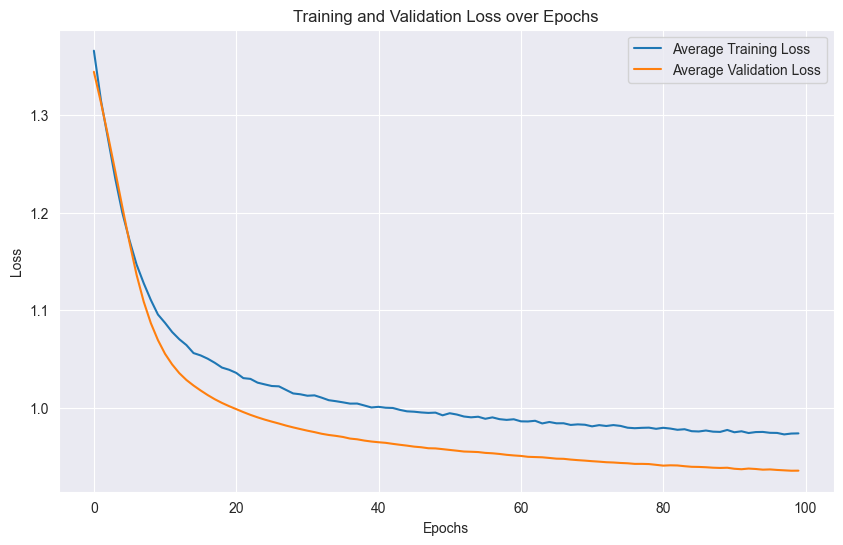

In [196]:
plot_training_history(final_histories)

In [197]:
final_combined_encoding = ensemble_encoding(final_autoencoders, test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [266]:
def compute_cluster_statistics(data, labels):

    data_with_labels = data.copy()
    data_with_labels['Cluster'] = labels
    
    cluster_stats = data_with_labels.groupby('Cluster').mean()
    
    return cluster_stats

In [267]:
def plot_cluster_statistics(cluster_stats, title='Cluster Statistics'):
    plt.figure(figsize=(20, 12)) 
    
    vmin = cluster_stats.min().min()
    vmax = cluster_stats.max().max()
    
    sns.heatmap(cluster_stats, annot=True, fmt='.2f', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout() 
    plt.show()

In [268]:
optimal_clusters_kmeans = find_optimal_clusters(final_combined_encoding, apply_kmeans_clustering, range(2, 11))
best_labels_kmeans = apply_kmeans_clustering(final_combined_encoding, optimal_clusters_kmeans)
silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(final_combined_encoding, best_labels_kmeans)
print(f'Test Set - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')


Silhouette Scores: [0.2994233, 0.2646023, 0.26367012, 0.26111728, 0.2551947, 0.18638329, 0.19903375, 0.20384194, 0.2089581]
Davies-Bouldin Scores: [1.4044926749245015, 1.409873120390838, 1.3364639420725388, 1.3019288588471019, 1.4095714945107265, 1.5636023392575111, 1.4350918843450111, 1.3337571732259461, 1.3231108140515067]
Inertia Scores: [226.58096313476562, 186.65872192382812, 161.82907104492188, 137.4917449951172, 128.63165283203125, 124.69674682617188, 112.33665466308594, 102.39903259277344, 94.02334594726562]
Optimal number of clusters determined: 5
Test Set - KMeans Silhouette Score: 0.26111727952957153, Davies-Bouldin Score: 1.3019288588471019


In [269]:
optimal_clusters_agg = find_optimal_clusters(final_combined_encoding, apply_agglomerative_clustering, range(2, 11))
best_labels_agg = apply_agglomerative_clustering(final_combined_encoding, optimal_clusters_agg)
silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(final_combined_encoding, best_labels_agg)
print(f'Test Set - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')

Silhouette Scores: [0.28237504, 0.20467868, 0.21096742, 0.21951923, 0.22350897, 0.20755863, 0.21199508, 0.22142567, 0.22718497]
Davies-Bouldin Scores: [1.4713857188844428, 1.4586701445942285, 1.4992780323512376, 1.4045672360250367, 1.469850737369917, 1.4398477830240355, 1.339293611894075, 1.251875694939593, 1.2702413966111965]
Inertia Scores: [226.58096313476562, 186.65872192382812, 161.82907104492188, 137.4917449951172, 128.63165283203125, 124.69674682617188, 112.33665466308594, 102.39903259277344, 94.02334594726562]
Optimal number of clusters determined: 5
Test Set - Agglomerative Silhouette Score: 0.2195192277431488, Davies-Bouldin Score: 1.4045672360250367


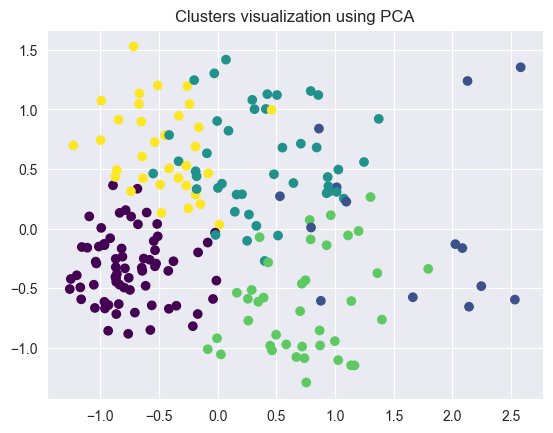

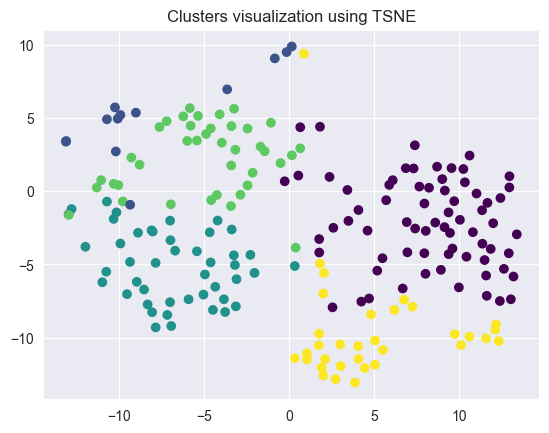

In [202]:
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='pca')
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='tsne')

In [203]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_clusters_3d(data, labels, method='pca'):
    """
    Visualizes clusters in the given data using PCA or t-SNE for 3D dimensionality reduction.
    
    Parameters:
    data (array-like): The data to be visualized.
    labels (array-like): The cluster labels assigned to the data.
    method (str): The method for dimensionality reduction ('pca' or 'tsne'). Default is 'pca'.
    
    Raises:
    ValueError: If the method is not recognized.
    """
    if method == 'pca':
        reducer = PCA(n_components=3)
    elif method == 'tsne':
        reducer = TSNE(n_components=3, random_state=42)
    else:
        raise ValueError("Method not recognized: choose 'pca' or 'tsne'")
        
    reduced_data = reducer.fit_transform(data)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title(f'Clusters visualization using {method.upper()}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()


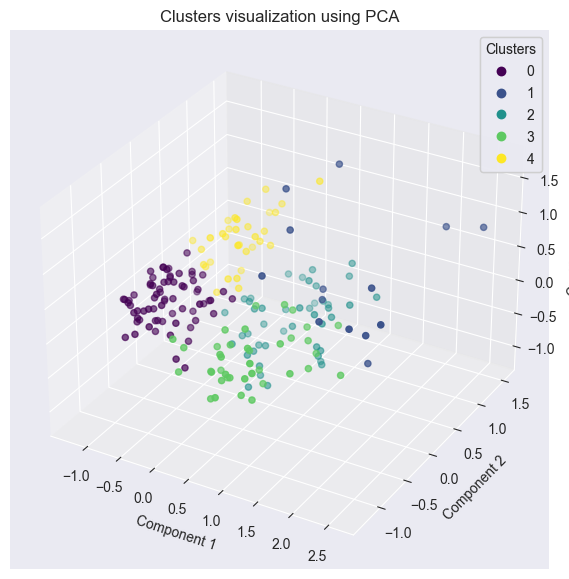

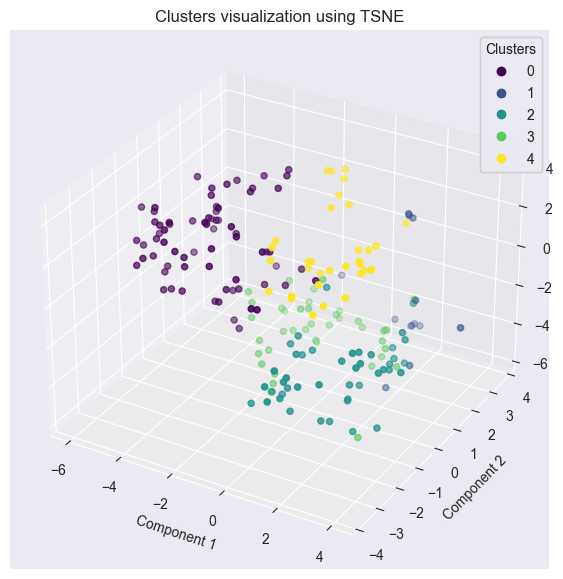

In [204]:
visualize_clusters_3d(final_combined_encoding, best_labels_kmeans, method='pca')
visualize_clusters_3d(final_combined_encoding, best_labels_kmeans, method='tsne')

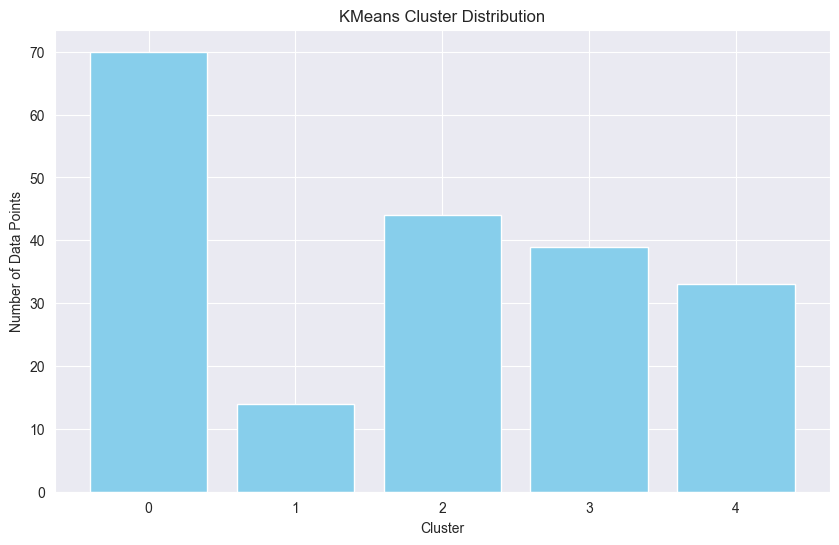

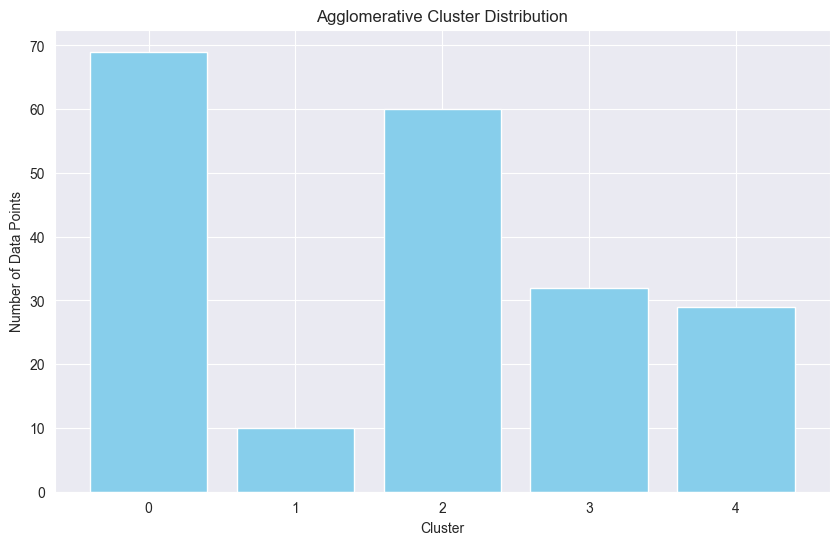

In [205]:
def plot_class_distribution(labels, title='Cluster Distribution'):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    
    plt.figure(figsize=(10, 6))
    plt.bar(distribution.keys(), distribution.values(), color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Data Points')
    plt.title(title)
    plt.show()

plot_class_distribution(best_labels_kmeans, title='KMeans Cluster Distribution')

plot_class_distribution(best_labels_agg, title='Agglomerative Cluster Distribution')


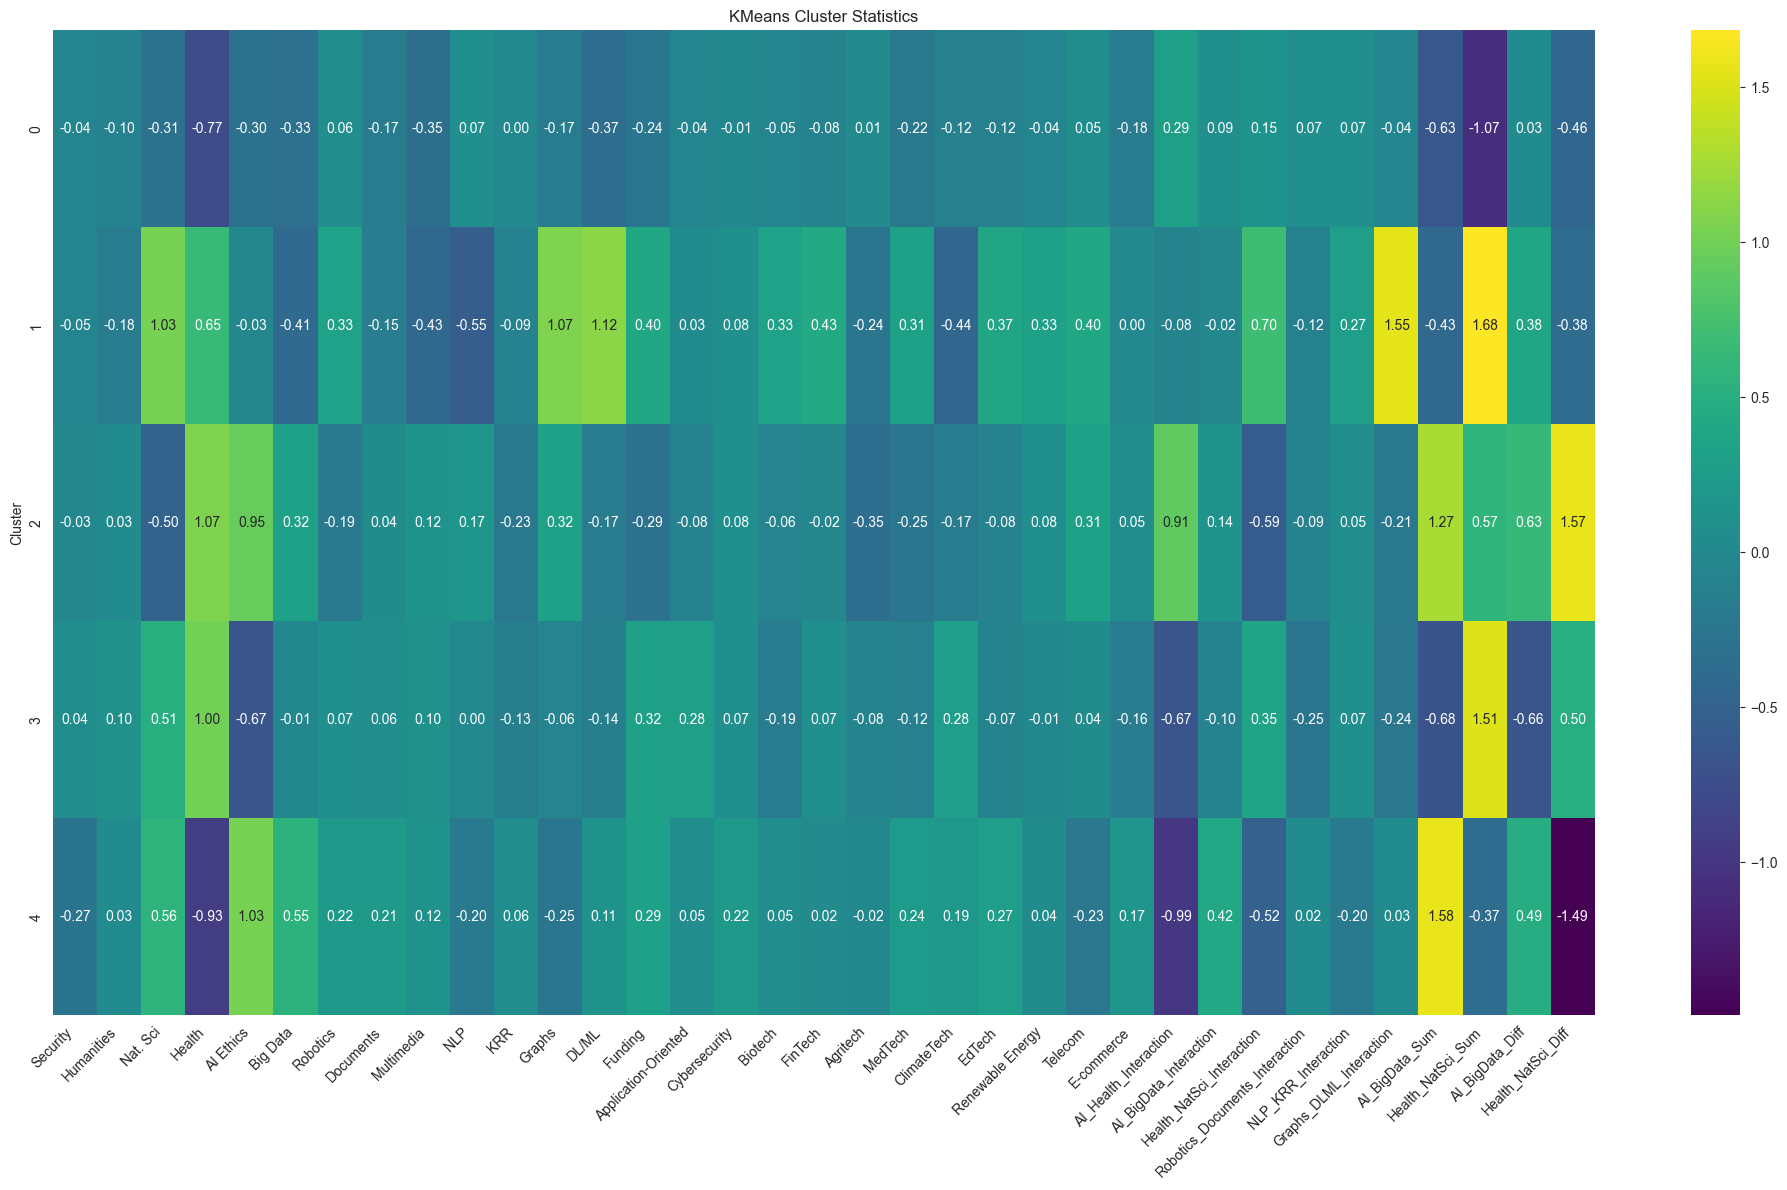

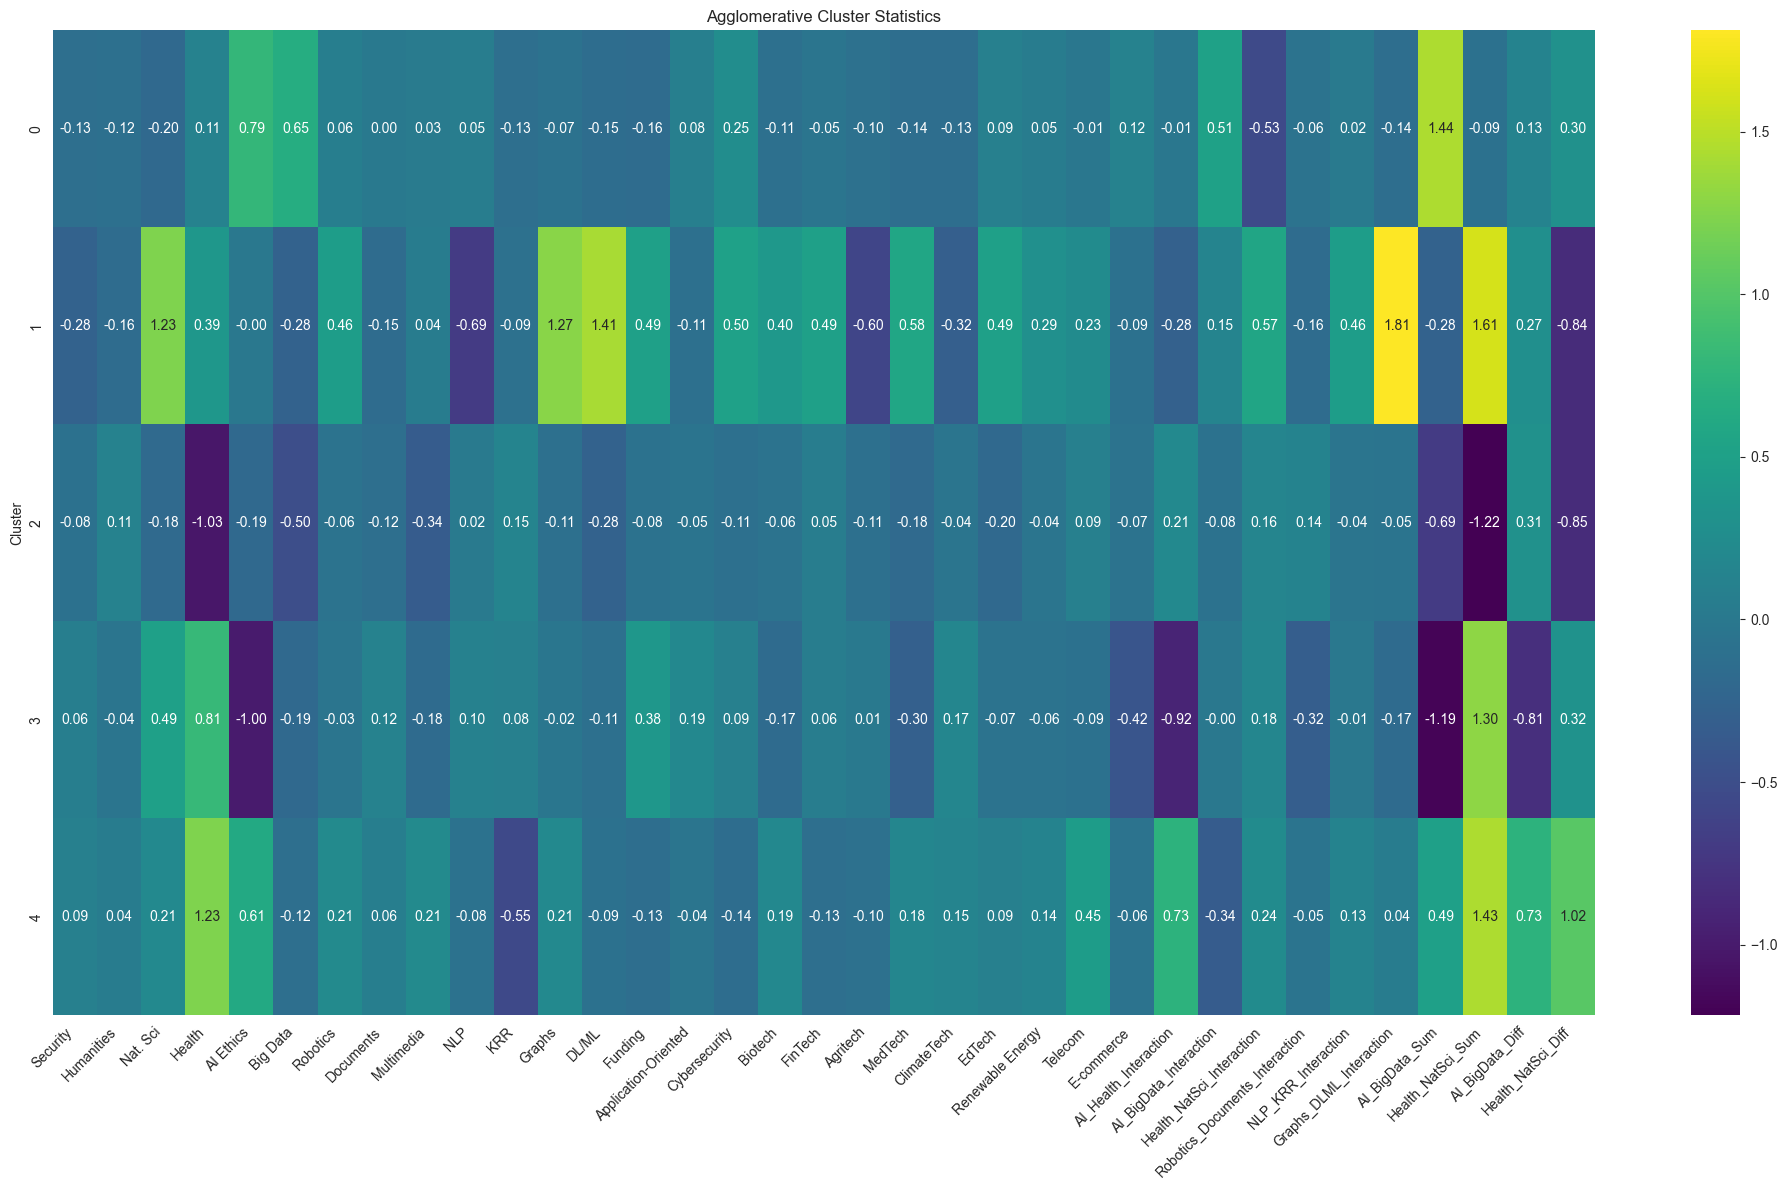

In [270]:
#FIXME: compute_cluster_statistics does not work with PCA reduction
cluster_stats_kmeans = compute_cluster_statistics(test_data, best_labels_kmeans)
cluster_stats_agg = compute_cluster_statistics(test_data, best_labels_agg)

# Plot the cluster statistics
plot_cluster_statistics(cluster_stats_kmeans, title='KMeans Cluster Statistics')
plot_cluster_statistics(cluster_stats_agg, title='Agglomerative Cluster Statistics')

In [207]:
from sklearn.model_selection import KFold
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def cross_validate_ensemble_model(autoencoder_func, train_data, n_splits=5, num_autoencoders=3):
    
    """
    Performs cross-validation on an ensemble of autoencoders and evaluates the clustering performance.
    
    Parameters:
    autoencoder_func (function): A function that trains multiple autoencoders and returns them along with their training histories.
    train_data (DataFrame): The training data.
    n_splits (int): The number of folds for cross-validation. Default is 5.
    num_autoencoders (int): The number of autoencoders to train in each fold. Default is 3.
    
    This function splits the training data into k folds, trains multiple autoencoders on each fold,
    and evaluates the clustering performance using KMeans and Agglomerative Clustering.
    """
    
    kf = KFold(n_splits=n_splits)
    fold = 1
    all_histories = []
    
    for train_index, val_index in kf.split(train_data):
        kf_train_data, val_data = train_data.iloc[train_index], train_data.iloc[val_index]
        autoencoders, histories = autoencoder_func(num_autoencoders, input_dim, best_params, kf_train_data)
        combined_encoding = ensemble_encoding(autoencoders, val_data)
        
        # KMeans
        optimal_clusters_kmeans = find_optimal_clusters(combined_encoding, apply_kmeans_clustering, range(2, 11))
        best_labels_kmeans = apply_kmeans_clustering(combined_encoding, optimal_clusters_kmeans)
        silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(combined_encoding, best_labels_kmeans)
        logging.info(f'Fold {fold} - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')
        
        # Agglomerative
        optimal_clusters_agg = find_optimal_clusters(combined_encoding, apply_agglomerative_clustering, range(2, 11))
        best_labels_agg = apply_agglomerative_clustering(combined_encoding, optimal_clusters_agg)
        silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(combined_encoding, best_labels_agg)
        logging.info(f'Fold {fold} - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')
        
        all_histories.extend(histories)
        fold += 1

    plot_training_history(all_histories)


In [ ]:
cross_validate_ensemble_model(train_multiple_autoencoders, train_data, n_splits=5, num_autoencoders=3)

Future Considerations:
1. Define new features to add specificity relevant to our use case
2. Integrate into preprocessing pipeline
3. Update clustering and evaluation workflow

For example:
1. Features that indicate high involvement in a specific industry
2. Performance metrics such as publication rate, industry success, project completion rate, etc.

Feature addition potential:
1. Domain specific features (industry metrics, experience)
2. Temporal features (growth rate, recency, industry activity etc.)

In [231]:
def calculate_cluster_statistics(data, labels):
    data_l = data.copy()
    data_l['Cluster'] = labels
    cluster_stats = data_l.groupby('Cluster').agg('mean', 'median', 'count' )
    return cluster_stats

In [245]:
cluster_statistics = calculate_cluster_statistics(test_data, best_labels_kmeans)
cluster_statistics

,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,AI_Health_Interaction,AI_BigData_Interaction,Health_NatSci_Interaction,Robotics_Documents_Interaction,NLP_KRR_Interaction,Graphs_DLML_Interaction,AI_BigData_Sum,Health_NatSci_Sum,AI_BigData_Diff,Health_NatSci_Diff
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.042525,-0.095941,-0.305608,-0.768636,-0.299097,-0.326766,0.058495,-0.172780,-0.347821,0.074191,...,0.290683,0.087535,0.149359,0.072097,0.069802,-0.041940,-0.625863,-1.074244,0.027669,-0.463029
1,-0.047113,-0.177170,1.033673,0.649331,-0.026133,-0.408491,0.332205,-0.154261,-0.430254,-0.553541,...,-0.078630,-0.019293,0.695169,-0.115628,0.269270,1.554875,-0.434624,1.683004,0.382359,-0.384341
2,-0.028346,0.025903,-0.500494,1.071610,0.950191,0.316926,-0.194547,0.044605,0.121380,0.171162,...,0.907479,0.144713,-0.585278,-0.089428,0.052811,-0.205289,1.267117,0.571116,0.633265,1.572104
3,0.044636,0.098801,0.508194,1.003795,-0.670392,-0.014416,0.070720,0.057636,0.095226,0.003976,...,-0.669412,-0.099772,0.352576,-0.247383,0.073497,-0.238835,-0.684808,1.511989,-0.655976,0.495601
4,-0.266753,0.025903,0.562460,-0.932025,1.030873,0.545661,0.219831,0.214009,0.121380,-0.197909,...,-0.986218,0.415051,-0.517036,0.024699,-0.201567,0.029311,1.576534,-0.369566,0.485212,-1.494485
